# Connection

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import xgboost as xgb

%matplotlib inline

# Import Data

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Exploration Data

In [3]:
df.shape

(5110, 12)

In [4]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Fill nan value with mean value

In [5]:
mean_bmi = df['bmi'].mean()

In [6]:
df['bmi'].fillna(value=mean_bmi, inplace = True)

df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

drop column id

In [7]:
df = df.drop(columns='id', axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


Because there are object in feature so we have to encode them

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
encode = LabelEncoder()

In [11]:
for x in list(df.select_dtypes('object').columns):
    df[x] = encode.fit_transform(df[x])

In [12]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int32  
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   int32  
 5   work_type          5110 non-null   int32  
 6   Residence_type     5110 non-null   int32  
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   int32  
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int32(5), int64(3)
memory usage: 339.5 KB


### Data Visualization

In [14]:
plt.style.use('fivethirtyeight')

#### Distplot

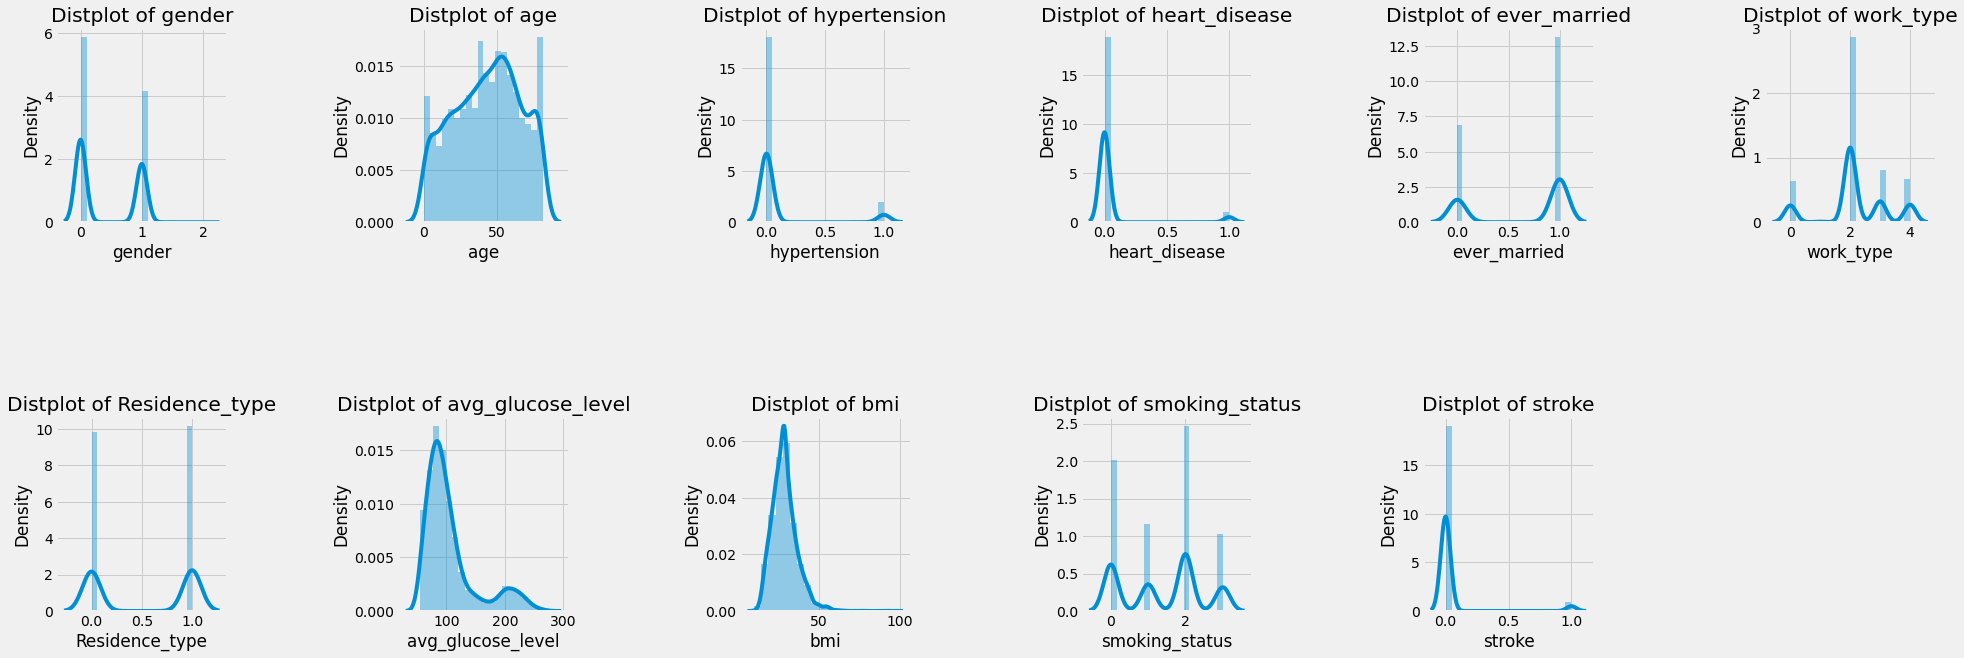

In [15]:
plt.figure(figsize=(30,10))
n = 0
for x in df.columns :
    n+= 1
    plt.subplot(2,6,n)
    plt.subplots_adjust(hspace=1, wspace = 1)
    sns.distplot(df[x], bins=20)
    plt.title('Distplot of {}'.format(x))
plt.show()

#### Boxplot

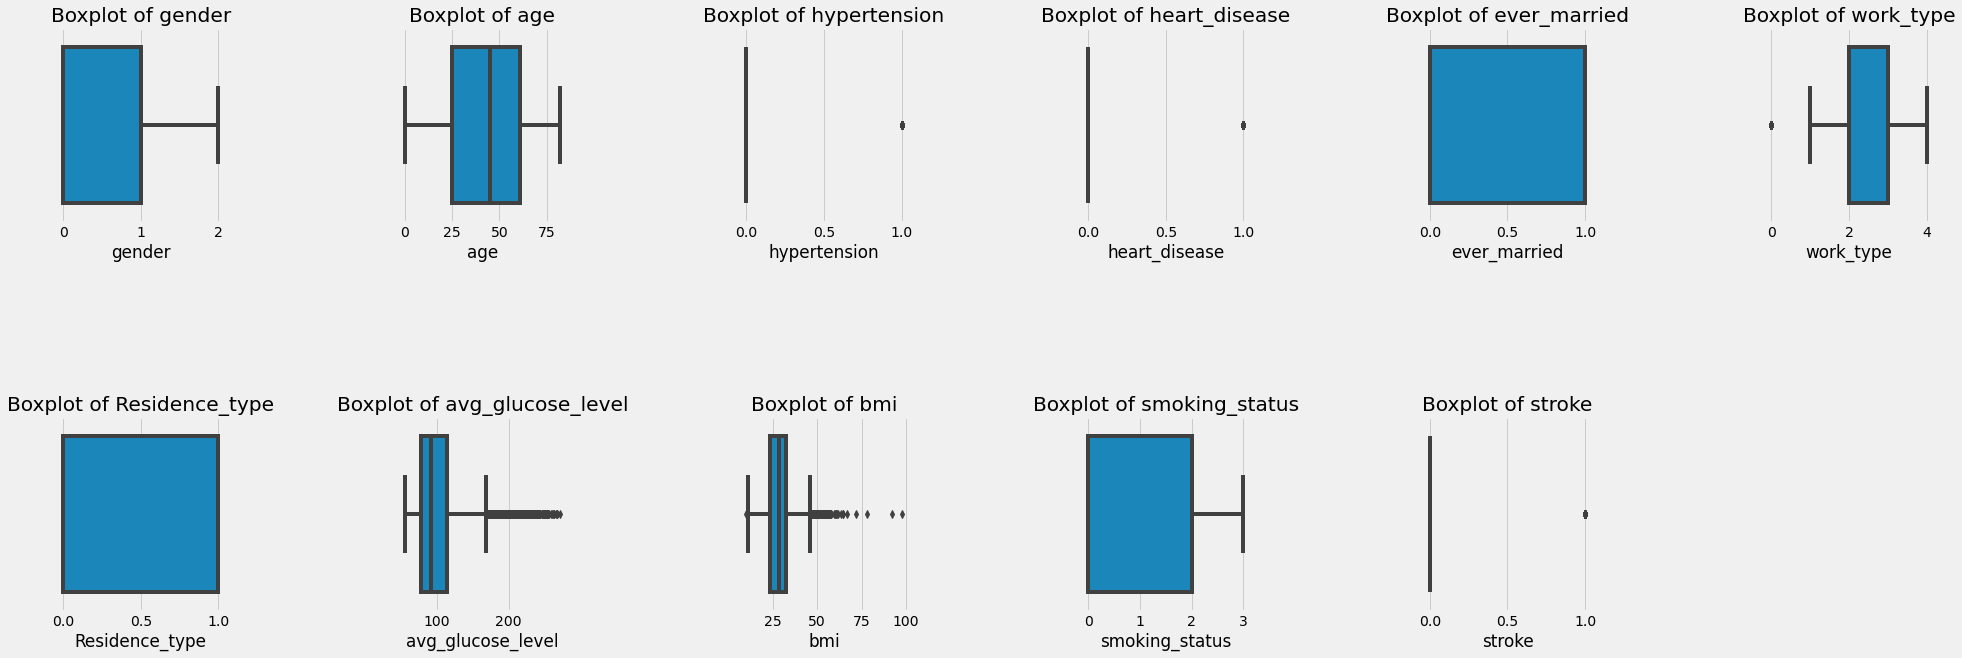

In [16]:
plt.figure(figsize=(30,10))
n = 0
for x in df.columns :
    n += 1 
    plt.subplot(2,6,n)
    plt.subplots_adjust(hspace=1,wspace=1)
    sns.boxplot(x=df[x])
    #sns.swarmplot(x=df[x])
    #sns.violinplot(y=df[x])
    plt.title('Boxplot of {}'.format(x))
plt.show()

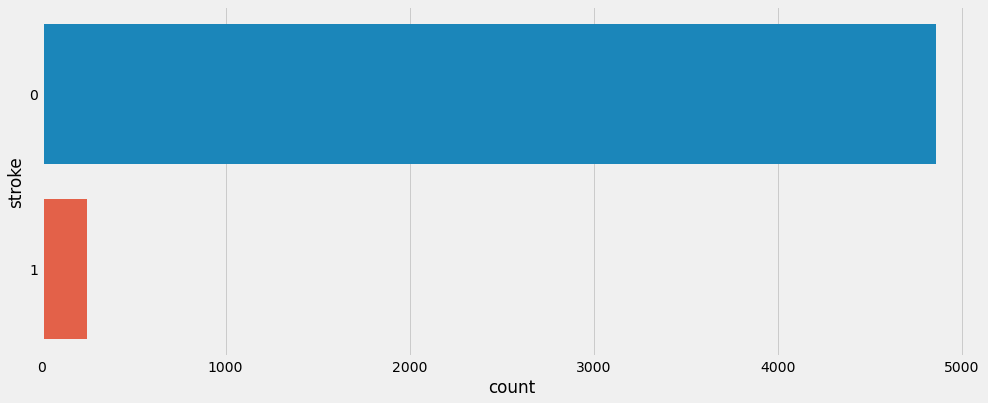

In [17]:
plt.figure(figsize=(15,6))
sns.countplot(y='stroke', data=df, order=df['stroke'].value_counts(ascending=False).index)
plt.show()

#### We have an imbalanced data 

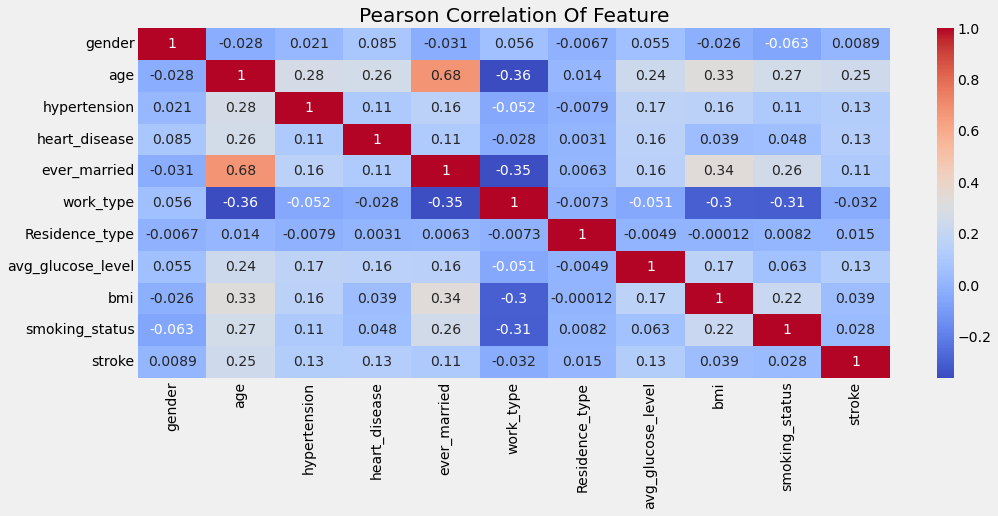

In [18]:
corr = df.corr(method='pearson')

plt.figure(figsize=(15,6))
sns.heatmap(corr, annot=True, cmap = 'coolwarm')
plt.title('Pearson Correlation Of Feature')
plt.show()

Feature ever married have strong correlation with age but overall the feature does not have strong correlation between each other

### Feature Importance

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
x = df.iloc[:,0:-1].copy()
y = df['stroke'].copy()

forest = RandomForestClassifier(max_depth=5, random_state=0)
forest.fit(x,y)

RandomForestClassifier(max_depth=5, random_state=0)

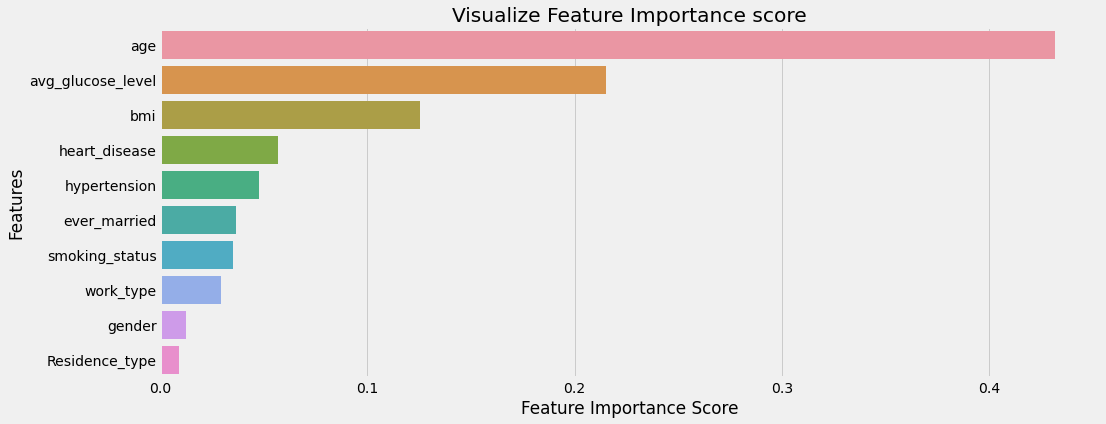

In [21]:
importances = forest.feature_importances_

forest_importances = pd.Series(importances, index = x.columns).sort_values(ascending=False)
plt.figure(figsize=(15,6))
sns.barplot(x=forest_importances, y=forest_importances.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualize Feature Importance score')
plt.show()

Age is most important feature on this model

# Feature Selection

In [22]:
from sklearn.feature_selection import RFE
model_rf = RandomForestClassifier(max_depth = 5, random_state=0)

In [23]:
rfe = RFE(model_rf)
fit = rfe.fit(x,y)

print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))

Num Features: 5
Selected Features: [False  True  True  True False False False  True  True False]


In [24]:
df_selected = x.iloc[:,fit.support_]
df_selected.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi
0,67.0,0,1,228.69,36.600000
1,61.0,0,0,202.21,28.893237
2,80.0,0,1,105.92,32.500000
3,49.0,0,0,171.23,34.400000
4,79.0,1,0,174.12,24.000000


### Splitting the data

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify = y, random_state=42)

In [26]:
x_train.shape

(3832, 10)

In [27]:
y_train.shape

(3832,)

# Preliminary Model

In [28]:
clf = xgb.XGBClassifier(missing=1, seed=42, use_label_encoder=False)

In [29]:
clf.fit(x_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric = 'aucpr', eval_set=[(x_test, y_test)])

[0]	validation_0-aucpr:0.20643
[1]	validation_0-aucpr:0.21233
[2]	validation_0-aucpr:0.19665
[3]	validation_0-aucpr:0.20158
[4]	validation_0-aucpr:0.19441
[5]	validation_0-aucpr:0.18302
[6]	validation_0-aucpr:0.17661
[7]	validation_0-aucpr:0.17659
[8]	validation_0-aucpr:0.18693
[9]	validation_0-aucpr:0.18946
[10]	validation_0-aucpr:0.18421
[11]	validation_0-aucpr:0.18265


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

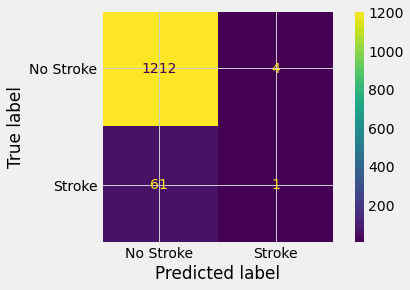

In [30]:
predicted = clf.predict(x_test)
cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Stroke', 'Stroke'])
disp.plot()

In [31]:
print('Precision: %.3f' % precision_score(y_test, predicted, average='macro'))
print('Recall: %.3f' % recall_score(y_test, predicted, average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_test, predicted))
print('F1 Score: %.3f' % f1_score(y_test, predicted, average='macro'))

Precision: 0.576
Recall: 0.506
Accuracy: 0.949
F1 Score: 0.502


# Tuning the Parameter

we use reg_lambda, learning_rate, gamma, max_depth and scale_pos_weight for tuning the parameter

In [32]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'reg_lambda' : [0,1.0,10.0],
    'max_depth' : [3,4,5],
    'learning_rate' : [0.01, 0.05, 0.1],
    'gamma' : [0,0.25,1.0],
    'scale_pos_weight' : [1,3,5]
}

optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic',
                                 seed = 42,
                                 subsample=0.9,
                                 colsample_bytree=0.5,
                                 use_label_encoder=False),
    param_grid = param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs = 10,
    cv = 3
)

optimal_params.fit(x_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='aucpr',
                   eval_set=[(x_test, y_test)],
                   verbose=True)
print(optimal_params.best_params_)

[0]	validation_0-aucpr:0.08288
[1]	validation_0-aucpr:0.20467
[2]	validation_0-aucpr:0.17932
[3]	validation_0-aucpr:0.16030
[4]	validation_0-aucpr:0.15413
[5]	validation_0-aucpr:0.14685
[6]	validation_0-aucpr:0.16636
[7]	validation_0-aucpr:0.16969
[8]	validation_0-aucpr:0.18032
[9]	validation_0-aucpr:0.17792
[10]	validation_0-aucpr:0.18406
{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'reg_lambda': 10.0, 'scale_pos_weight': 5}


Because just max_dept who get value in the middle so we have to adjust again to round 2

In [33]:
param_grid = {
    'reg_lambda' : [10.0, 15.0, 20.0],
    'max_depth' : [4],
    'learning_rate' : [0.01, 0.005, 0.001],
    'gamma' : [1.0, 1.5, 2],
    'scale_pos_weight' : [5,6,7]
}

optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic',
                                 seed = 42,
                                 subsample=0.9,
                                 colsample_bytree=0.5,
                                 use_label_encoder=False),
    param_grid = param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs = 10,
    cv = 3
)

optimal_params.fit(x_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='aucpr',
                   eval_set=[(x_test, y_test)],
                   verbose=True)
print(optimal_params.best_params_)

[0]	validation_0-aucpr:0.09421
[1]	validation_0-aucpr:0.21968
[2]	validation_0-aucpr:0.17487
[3]	validation_0-aucpr:0.16731
[4]	validation_0-aucpr:0.15886
[5]	validation_0-aucpr:0.14836
[6]	validation_0-aucpr:0.17087
[7]	validation_0-aucpr:0.16678
[8]	validation_0-aucpr:0.18039
[9]	validation_0-aucpr:0.17636
[10]	validation_0-aucpr:0.18051
{'gamma': 1.0, 'learning_rate': 0.005, 'max_depth': 4, 'reg_lambda': 20.0, 'scale_pos_weight': 6}


value of reg_lambda is rightmost so we have to try bigger value for reg_lambda

In [34]:
param_grid = {
    'reg_lambda' : [20.0, 25.0,30.0],
    'max_depth' : [4],
    'learning_rate' : [0.005],
    'gamma' : [1.0],
    'scale_pos_weight' : [6]
}

optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic',
                                 seed = 42,
                                 subsample=0.9,
                                 colsample_bytree=0.5,
                                 use_label_encoder=False),
    param_grid = param_grid,
    scoring='roc_auc',
    verbose=0,
    n_jobs = 10,
    cv = 3
)

optimal_params.fit(x_train,
                   y_train,
                   early_stopping_rounds=10,
                   eval_metric='aucpr',
                   eval_set=[(x_test, y_test)],
                   verbose=True)
print(optimal_params.best_params_)

[0]	validation_0-aucpr:0.09421
[1]	validation_0-aucpr:0.21968
[2]	validation_0-aucpr:0.17487
[3]	validation_0-aucpr:0.16731
[4]	validation_0-aucpr:0.15886
[5]	validation_0-aucpr:0.14836
[6]	validation_0-aucpr:0.17087
[7]	validation_0-aucpr:0.16678
[8]	validation_0-aucpr:0.18039
[9]	validation_0-aucpr:0.17636
[10]	validation_0-aucpr:0.18051
[11]	validation_0-aucpr:0.18863
{'gamma': 1.0, 'learning_rate': 0.005, 'max_depth': 4, 'reg_lambda': 20.0, 'scale_pos_weight': 6}


we got the optimum parameter then try to fit to model

In [35]:
clf_optimum = xgb.XGBClassifier(missing=1, seed=42, use_label_encoder=False, objective='binary:logistic', gamma = 1.0, learning_rate=0.005, 
                                max_depth=4, reg_lambda= 20.0, scale_pos_weight= 6)

In [36]:
clf_optimum.fit(x_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric = 'aucpr', eval_set=[(x_test, y_test)])

[0]	validation_0-aucpr:0.16170
[1]	validation_0-aucpr:0.18821
[2]	validation_0-aucpr:0.18970
[3]	validation_0-aucpr:0.19159
[4]	validation_0-aucpr:0.19159
[5]	validation_0-aucpr:0.19076
[6]	validation_0-aucpr:0.18709
[7]	validation_0-aucpr:0.18924
[8]	validation_0-aucpr:0.19050
[9]	validation_0-aucpr:0.19126
[10]	validation_0-aucpr:0.19160
[11]	validation_0-aucpr:0.19055
[12]	validation_0-aucpr:0.19240
[13]	validation_0-aucpr:0.18735
[14]	validation_0-aucpr:0.18610
[15]	validation_0-aucpr:0.18589
[16]	validation_0-aucpr:0.18496
[17]	validation_0-aucpr:0.18589
[18]	validation_0-aucpr:0.18732
[19]	validation_0-aucpr:0.18450
[20]	validation_0-aucpr:0.18527
[21]	validation_0-aucpr:0.18548
[22]	validation_0-aucpr:0.18519


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.005, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=20.0, scale_pos_weight=6, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

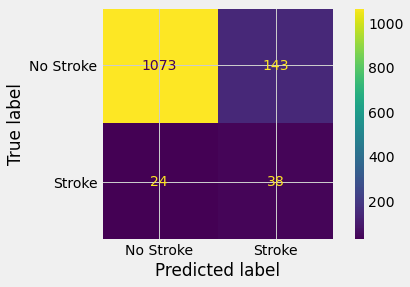

In [37]:
predicted_optimum = clf_optimum.predict(x_test)
cm = confusion_matrix(y_test, predicted_optimum)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No Stroke', 'Stroke'])
disp.plot()

In [38]:
print('Precision: %.3f' % precision_score(y_test, predicted_optimum, average='macro'))
print('Recall: %.3f' % recall_score(y_test, predicted_optimum, average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_test, predicted_optimum))
print('F1 Score: %.3f' % f1_score(y_test, predicted_optimum, average='macro'))

Precision: 0.594
Recall: 0.748
Accuracy: 0.869
F1 Score: 0.620


After tuning the parameter we got higher recall, precision and F1 Score have higher score

# Conclusion

- The most importance feature for this model is 'age'
- The optimum parameter after tuning the model is gamma:1, learning_rate:0.005, reg_lambda:20, max_depth:4 and scale_pos_weight:6
- Score we got precision 59%, recall 74%, accuracy 86% and F1 Score 62%

Like and share if you love my model, thanky you